<a href="https://colab.research.google.com/github/vishal-jpeg/CKD/blob/main/Chronic_Kidney_Diseases_Prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv(r'/content/kidney_disease.csv')
columns = pd.read_csv(r'/content/data_description.txt', sep='-')
columns = columns.reset_index()
columns.columns = ['cols', 'abb_col_names']
df.columns = columns['abb_col_names'].values
print("Dataset loaded successfully.\n")

Loading dataset...
Dataset loaded successfully.



In [ ]:
# Convert dtype of specific features
print("Converting data types for specific features...")
def convert_dtype(df, feature):
    df[feature] = pd.to_numeric(df[feature], errors='coerce')
features = ['packed cell volume', 'white blood cell count', 'red blood cell count']
for feature in features:
    convert_dtype(df, feature)
print("Data types converted.\n")

Converting data types for specific features...
Data types converted.



In [ ]:
# Data Wrangling
print("Dropping unnecessary columns...")
df.drop('id', axis=1, inplace=True)
print("Columns dropped.\n")

Dropping unnecessary columns...
Columns dropped.



In [ ]:
# Extract Numerical & Categorical Features
print("Extracting numerical and categorical features...")
def extract_cat_num(df):
    cat_col = [col for col in df.columns if df[col].dtype == 'object']
    num_col = [col for col in df.columns if df[col].dtype != 'object']
    return cat_col, num_col
cat_col, num_col = extract_cat_num(df)
print(f"Categorical columns: {cat_col}")
print(f"Numerical columns: {num_col}\n")

Extracting numerical and categorical features...
Categorical columns: ['red blood cells', 'pus cell', 'pus cell clumps', 'bacteria', 'ypertension', 'diabetes mellitus', 'coronary artery disease', 'appetite', 'pedal edema', 'anemia', 'class']
Numerical columns: ['age', 'blood pressure', 'specific gravity', 'albumin', 'sugar', 'blood glucose random', 'blood urea', 'serum creatinine', 'sodium', 'potassium', 'haemoglobin', 'packed cell volume', 'white blood cell count', 'red blood cell count']



In [ ]:
# Replace incorrect values
print("Replacing incorrect values in categorical columns...")
df['diabetes mellitus'].replace(to_replace={'\tno':'no', '\tyes':'yes', ' yes':'yes'}, inplace=True)
df['coronary artery disease'] = df['coronary artery disease'].replace(to_replace='\tno', value='no')
df['class'] = df['class'].replace(to_replace='ckd\t', value='ckd')
print("Incorrect values replaced.\n")

Replacing incorrect values in categorical columns...
Incorrect values replaced.



In [ ]:
# Handle missing values
print("Handling missing values...")
data = df.copy()
for col in num_col:
    random_sample = data[col].dropna().sample(data[col].isnull().sum())
    random_sample.index = data[data[col].isnull()].index
    data.loc[data[col].isnull(), col] = random_sample

Handling missing values...


In [ ]:
def impute_mode(feature):
    mode = data[feature].mode()[0]
    data[feature] = data[feature].fillna(mode)
for col in cat_col:
    impute_mode(col)
print("Missing values handled.\n")

Missing values handled.



In [ ]:
# Encode categorical features
print("Encoding categorical features...")
le = LabelEncoder()
for col in cat_col:
    data[col] = le.fit_transform(data[col])
print("Categorical features encoded.\n")

Encoding categorical features...
Categorical features encoded.



In [ ]:
# Feature Selection
print("Selecting top features using SelectKBest...")
X = data.drop('class', axis=1)
y = data['class']
order_rank_features = SelectKBest(score_func=chi2, k=20)
X_new = order_rank_features.fit_transform(X, y)
selected_columns = order_rank_features.get_support(indices=True)
selected_columns_names = X.columns[selected_columns]  # Save selected columns
print(f"Top selected features: {selected_columns_names}\n")

Selecting top features using SelectKBest...
Top selected features: Index(['age', 'blood pressure', 'albumin', 'sugar', 'pus cell clumps',
       'bacteria', 'blood glucose random', 'blood urea', 'serum creatinine',
       'sodium', 'haemoglobin', 'packed cell volume', 'white blood cell count',
       'red blood cell count', 'ypertension', 'diabetes mellitus',
       'coronary artery disease', 'appetite', 'pedal edema', 'anemia'],
      dtype='object')



Plotting feature importance...


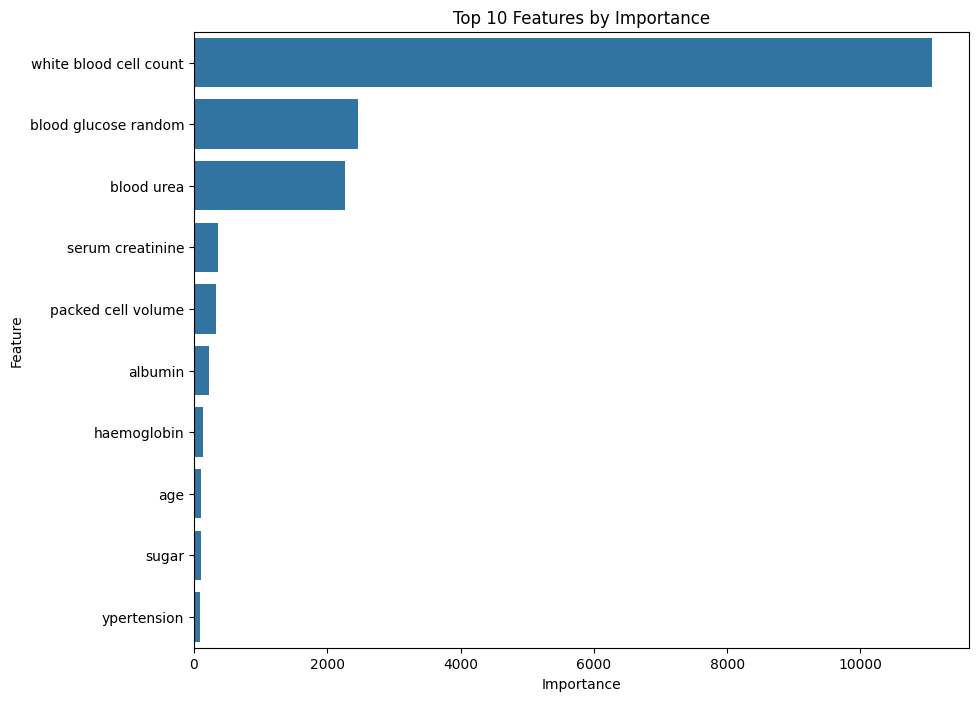

In [ ]:
# Plot feature importance
print("Plotting feature importance...")
features_rank = pd.DataFrame({
    'Feature': X.columns,
    'Importance': order_rank_features.scores_
})
features_rank = features_rank.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_rank)
plt.title('Top 10 Features by Importance')
plt.show()

In [ ]:
# Train-test split
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
print("Data split completed.\n")

Splitting data into training and testing sets...
Data split completed.



In [ ]:
# Model training
print("Training the model...")
classifier = XGBClassifier(
    colsample_bytree=0.3,
    gamma=0.4,
    learning_rate=0.25,
    max_depth=8,
    n_estimators=100,
    objective='binary:logistic'
)
classifier.fit(X_train, y_train)
print("Model trained successfully.\n")

Training the model...
Model trained successfully.



In [ ]:
# Evaluate model
print("Evaluating the model...")
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model is: {accuracy * 100:.2f}%\n")

Evaluating the model...
Accuracy of the model is: 100.00%



Plotting confusion matrix...


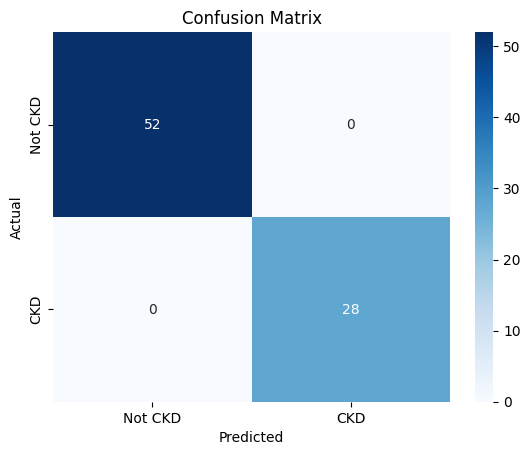

In [ ]:
# Confusion matrix plot
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Save label encoder classes for later use
le_classes = {}
for col in cat_col:
    le_classes[col] = le.classes_
print("Label encoder classes saved for later use.\n")

Label encoder classes saved for later use.



In [ ]:
# Function for user input and prediction
def predict_ckd(input_data):
    input_df = pd.DataFrame([input_data], columns=selected_columns_names)
    for col in cat_col:
        if col in input_df.columns:
            input_df[col] = input_df[col].map(lambda x: list(le_classes[col]).index(x) if x in le_classes[col] else np.nan)
    input_df = input_df[selected_columns_names]
    prediction = classifier.predict(input_df)
    return 'Not CKD' if prediction[0] == 1 else 'CKD'

In [ ]:
# Get user input
def get_user_input():
    print("Please enter the following details:")
    input_data = {}
    input_data['age'] = float(input("Enter age: "))
    input_data['blood pressure'] = float(input("Enter blood pressure: "))
    input_data['specific gravity'] = float(input("Enter specific gravity: "))
    input_data['albumin'] = float(input("Enter albumin: "))
    input_data['sugar'] = float(input("Enter sugar: "))
    input_data['red blood cells'] = input("Enter red blood cells (normal/abnormal): ")
    input_data['pus cell'] = input("Enter pus cell (normal/abnormal): ")
    input_data['pus cell clumps'] = input("Enter pus cell clumps (notpresent/present): ")
    input_data['bacteria'] = input("Enter bacteria (notpresent/present): ")
    input_data['blood glucose random'] = float(input("Enter blood glucose random: "))
    input_data['blood urea'] = float(input("Enter blood urea: "))
    input_data['serum creatinine'] = float(input("Enter serum creatinine: "))
    input_data['sodium'] = float(input("Enter sodium: "))
    input_data['potassium'] = float(input("Enter potassium: "))
    input_data['haemoglobin'] = float(input("Enter haemoglobin: "))
    input_data['packed cell volume'] = float(input("Enter packed cell volume: "))
    input_data['white blood cell count'] = float(input("Enter white blood cell count: "))
    input_data['red blood cell count'] = float(input("Enter red blood cell count: "))
    input_data['hypertension'] = input("Enter hypertension (yes/no): ")
    input_data['diabetes mellitus'] = input("Enter diabetes mellitus (yes/no): ")
    input_data['coronary artery disease'] = input("Enter coronary artery disease (yes/no): ")
    input_data['appetite'] = input("Enter appetite (good/poor): ")
    input_data['pedal edema'] = input("Enter pedal edema (yes/no): ")
    input_data['anemia'] = input("Enter anemia (yes/no): ")
    return input_data

In [ ]:
a0# Predict CKD based on user input
print("\nReady to predict CKD based on user input.")
user_input = get_user_input()
result = predict_ckd(user_input)
print(f"\nThe prediction based on the input is: {result}")

# Additional Plots for Presentation
print("Creating additional plots for presentation...")


Ready to predict CKD based on user input.
Please enter the following details:
Enter age: 64
Enter blood pressure: 100
Enter specific gravity: 1.015
Enter albumin: 4
Enter sugar: 2
Enter red blood cells (normal/abnormal): abnormal
Enter pus cell (normal/abnormal): abnormal
Enter pus cell clumps (notpresent/present): notpresent
Enter bacteria (notpresent/present): present
Enter blood glucose random: 163
Enter blood urea: 54
Enter serum creatinine: 7.2
Enter sodium: 140
Enter potassium: 4.6
Enter haemoglobin: 7.9
Enter packed cell volume: 26
Enter white blood cell count: 7500
Enter red blood cell count: 3.4
Enter hypertension (yes/no): yes
Enter diabetes mellitus (yes/no): yes
Enter coronary artery disease (yes/no): no
Enter appetite (good/poor): good
Enter pedal edema (yes/no): yes
Enter anemia (yes/no): no

The prediction based on the input is: CKD
Creating additional plots for presentation...


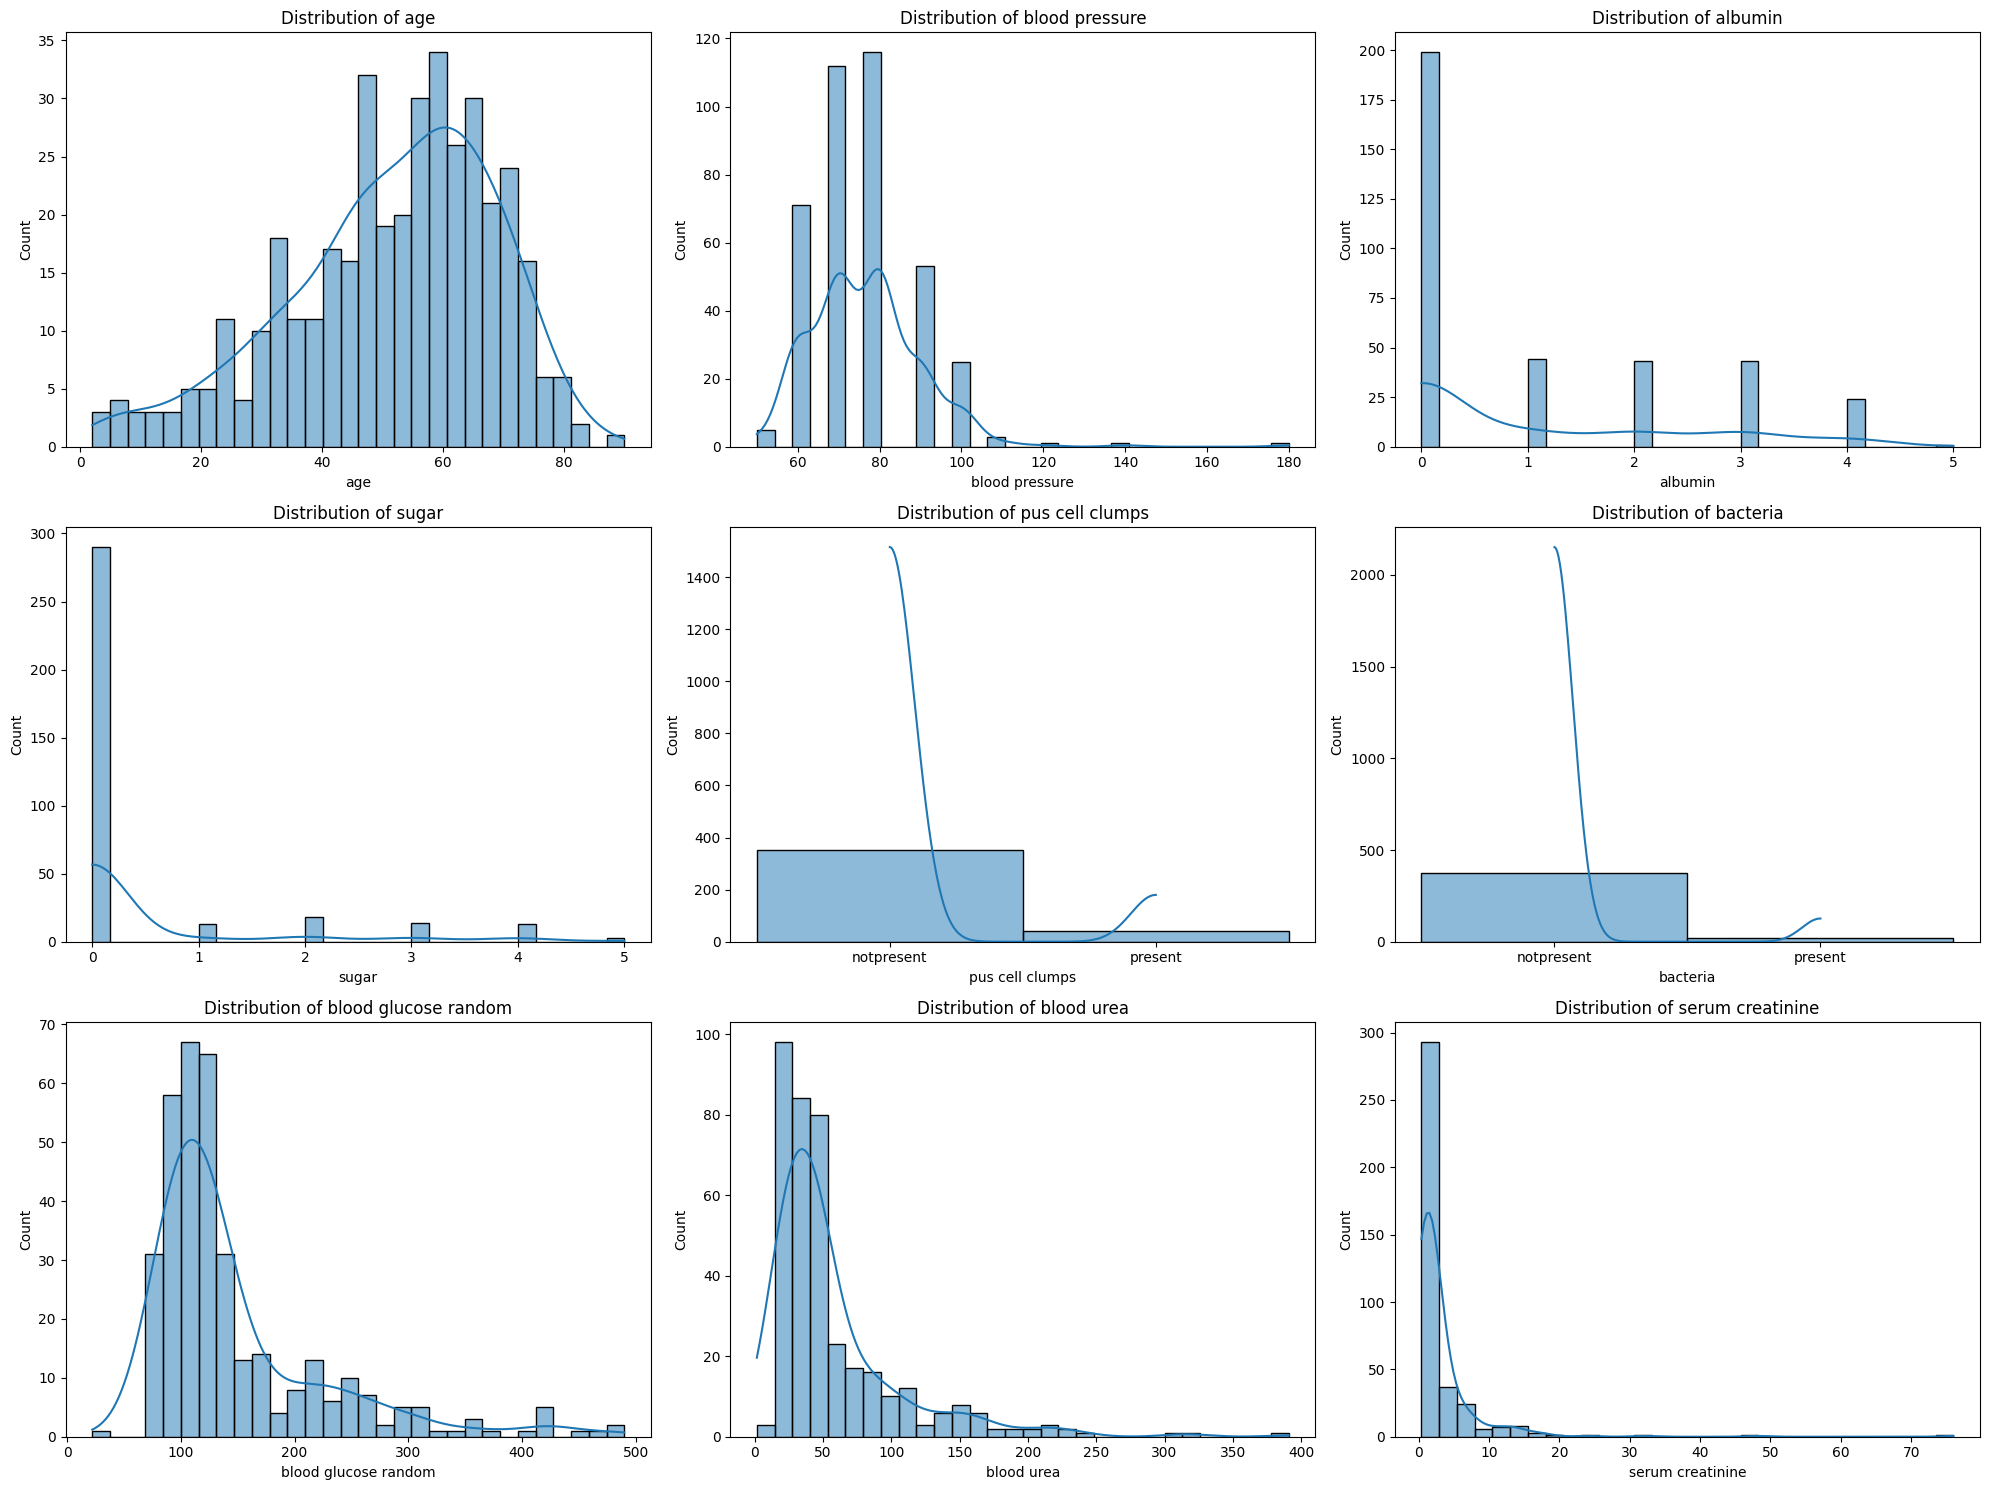

In [ ]:
# Plot distribution of selected numerical features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(selected_columns_names[:9]):  # Plotting the first 9 selected features
    plt.subplot(3, 3, i+1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
# Plot scatter matrix for top 3 features
top_3_features = selected_columns_names[:3]
fig = px.scatter_matrix(df, dimensions=top_3_features, color='class',
                        title='Scatter Matrix of Top 3 Features')
fig.show()

print("Additional plots created.\n")

Additional plots created.

